In [1]:
import argparse
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from torch_frame import stype
import os
import glob
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from torch_frame import stype
# Model imports
from data_provider_pretrain.data_factory import data_provider
from models.time_series_flow_matching_model import TimeSeriesFlowMatchingModel
from models.model9_NS_transformer.flow_matching_models.flow_matching_utils import sample_flow_matching

# Set random seeds
torch.manual_seed(220)
np.random.seed(220)

# Styling
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('default')
sns.set_palette("husl")

print("Imports successful!")



Imports successful!


In [2]:
# Configuration and utility functions from diffusion_analysis.ipynb
class DotDict(dict):
    """A dictionary that supports both dot notation and dictionary access."""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__dict__ = self

    def __getattr__(self, attr):
        return self.get(attr)

    def __setattr__(self, key, value):
        self.__dict__[key] = value

    def __delattr__(self, item):
        self.__dict__.pop(item, None)

# Flow matching configuration
flow_matching_config = DotDict({
    "num_nodes": 1,
    "task_name": "long_term_forecast",
    "is_training": 1,
    "model_id": "ETTh1_ETTh2_512_192",
    "model": "ns_DLinear",
    "precision": "32",
    "generative_model": "flow_matching",
    "data_pretrain": "Glucose",
    "root_path": "/home/yl2428/Time-LLM/dataset/glucose",
    "data_path": "output_Junt_16_3.csv",
    "data_path_pretrain": "output_Junt_16_3.csv",
    "features": "MS",
    "target": "OT",
    "freq": "t",
    "checkpoints": "/home/yl2428/checkpoints",
    "log_dir": "/home/yl2428/logs",
    "seq_len": 72,
    "label_len": 32,
    "pred_len": 48,
    "seasonal_patterns": "Monthly",
    "stride": 1,
    "enc_in": 9,
    "dec_in": 9,
    "c_out": 9,
    "d_model": 32,
    "n_heads": 8,
    "e_layers": 2,
    "d_layers": 1,
    "d_ff": 256,
    "moving_avg": 25,
    "factor": 3,
    "dropout": 0.1,
    "embed": "timeF",
    "activation": "gelu",
    "output_attention": False,
    "patch_len": 16,
    "prompt_domain": 0,
    "llm_model": "LLAMA",
    "llm_dim": 4096,
    "vae_hidden_dim": 16,
    "col_stats": {'SEX': {'COUNT': (['F', 'M'], [367, 135])}, 'RACE': {'COUNT': (['WHITE', 'NOT REPORTED', 'ASIAN', 'BLACK/AFRICAN AMERICAN', 'MULTIPLE', 'UNKNOWN', 'AMERICAN INDIAN/ALASKAN NATIVE'], [459, 11, 10, 10, 8, 2, 2])}, 'ETHNIC': {'COUNT': (['Not Hispanic or Latino', 'Hispanic or Latino', 'Do not wish to answer', "Don't know"], [472, 15, 13, 2])}, 'ARMCD': {'COUNT': (['RESISTANCE', 'INTERVAL', 'AEROBIC'], [172, 167, 163])}, 'insulin modality': {'COUNT': (['CLOSED LOOP INSULIN PUMP', 'INSULIN PUMP', 'MULTIPLE DAILY INJECTIONS'], [225, 189, 88])}, 'AGE': {'MEAN': 36.655378486055774, 'STD': 13.941209833786187, 'QUANTILES': [18.0, 25.0, 33.0, 45.75, 70.0]}, 'WEIGHT': {'MEAN': 161.39940239043824, 'STD': 30.624877585598654, 'QUANTILES': [103.0, 140.0, 155.0, 179.0, 280.0]}, 'HEIGHT': {'MEAN': 66.72509960159363, 'STD': 3.505847063905933, 'QUANTILES': [58.0, 64.0, 66.0, 69.0, 77.0]}, 'HbA1c': {'MEAN': 6.642828685258964, 'STD': 0.7633658734231158, 'QUANTILES': [4.8, 6.1, 6.6, 7.1, 10.0]}, 'DIABETES_ONSET': {'MEAN': 18.72725737051793, 'STD': 11.889102915798386, 'QUANTILES': [0.0833, 11.0, 16.0, 24.0, 66.0]}},
    "col_names_dict": {
        stype.categorical: ['ARMCD', 'ETHNIC', 'RACE', 'SEX', 'insulin modality'],
        stype.numerical: ['AGE', 'DIABETES_ONSET', 'HEIGHT', 'HbA1c', 'WEIGHT']
    },
    "num_workers": 10,
    "itr": 1,
    "train_epochs": 100,
    "align_epochs": 10,
    "ema_decay": 0.995,
    "batch_size": 512,  # Updated from 256 to 64
    "eval_batch_size": 512,  # Updated from 256 to 8
    "patience": 40,  # Updated from 10 to 40
    "learning_rate": 0.0001,
    "des": "Exp",
    "loss": "MSE",
    "lradj": "COS",
    "pct_start": 0.2,
    "use_amp": False,
    "llm_layers": 32,
    "percent": 100,
    "num_individuals": -1,  # Updated from 100 to -1
    "enable_covariates": 1,
    "cov_type": "tensor",
    "gradient_accumulation_steps": 1,
    "use_deep_speed": 1,
    "wandb": 1,
    "wandb_group": None,
    "wandb_api_key": "6f1080f993d5d7ad6103e69ef57dd9291f1bf366",
    "use_moe": 1,
    "num_experts": 8,
    "latent_len": 36,
    "top_k_experts": 4,
    "moe_layer_indices": [0, 1],
    "moe_loss_weight": 0.01,
    "log_routing_stats": 1,
    "num_universal_experts": 1,
    "universal_expert_weight": 0.3,
    "head_dropout": 0.1,
    "channel_independence": 0,
    "decomp_method": "moving_avg",
    "use_norm": 1,
    "down_sampling_layers": 2,
    "down_sampling_window": 1,
    "down_sampling_method": "avg",
    "use_future_temporal_feature": 0,
    "k_z": 1e-2,
    "k_cond": 0.001,  # Updated from 1 to 0.001
    "d_z": 8,
    "p_hidden_dims": [64, 64],
    "p_hidden_layers": 2,
    "diffusion_config_dir": "/home/yl2428/Time-LLM/models/model9_NS_transformer/configs/toy_8gauss.yml",
    "cond_pred_model_pertrain_dir": None,
    "CART_input_x_embed_dim": 32,
    "mse_timestep": 0,
    "MLP_diffusion_net": False,
    "timesteps": 50,
    "ode_solver": "dopri5",
    "ode_rtol": 1e-5,
    "ode_atol": 1e-5,
    "interpolation_type": "linear",
    "expert_layers": 2,
    # Additional fields from JSON that were missing:
    "loader": "modal",
    "model_comment": "none",
    "enable_context_aware": 1,
})

def find_best_checkpoint(base_path="/home/yl2428/logs/ns_DLinear/flow_matching/major-elevator-239", metric="val_loss"):
    """Find the best checkpoint based on validation loss."""
    print(f"Searching for checkpoints in: {base_path}")
    
    checkpoint_pattern = os.path.join(base_path, "checkpoints/epoch=*-step=*-val_loss=*.ckpt/checkpoint")
    print(checkpoint_pattern)
    checkpoint_dirs = glob.glob(checkpoint_pattern)
    
    if not checkpoint_dirs:
        print("No checkpoints found!")
        return None, None, None
    
    best_checkpoint = None
    best_metric = float('inf')
    best_run = None
    
    print(f"Found {len(checkpoint_dirs)} checkpoints:")
    
    for checkpoint_dir in checkpoint_dirs:
        pattern = r'epoch=(\d+)-step=(\d+)-val_loss=([\d.]+)\.ckpt'
        match = re.search(pattern, checkpoint_dir)
        
        if match:
            epoch, step, val_loss = match.groups()
            val_loss = float(val_loss)
            run_name = checkpoint_dir.split('/')[-4]
            
            print(f"  - {run_name}: epoch={epoch}, step={step}, val_loss={val_loss:.4f}")
            
            if val_loss < best_metric:
                best_metric = val_loss
                best_checkpoint = checkpoint_dir
                best_run = run_name
    
    if best_checkpoint:
        print(f"\nBest checkpoint: {best_run}")
        print(f"  - Path: {best_checkpoint}")
        print(f"  - Val Loss: {best_metric:.4f}")
    
    return best_checkpoint, best_metric, best_run


def load_deepspeed_checkpoint(model, checkpoint_path):
    """Load DeepSpeed checkpoint into the model."""
    print(f"Loading DeepSpeed checkpoint from: {checkpoint_path}")
    
    model_states_path = os.path.join(checkpoint_path, "mp_rank_00_model_states.pt")
    
    if not os.path.exists(model_states_path):
        raise FileNotFoundError(f"Model states file not found: {model_states_path}")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    checkpoint = torch.load(model_states_path, map_location=device)
    
    if 'module' in checkpoint:
        state_dict = checkpoint['module']
    elif 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint
    
    cleaned_state_dict = {}
    for key, value in state_dict.items():
        clean_key = key
        if key.startswith('_forward_module.'):
            clean_key = key.replace('_forward_module.', '')
        elif key.startswith('module.'):
            clean_key = key.replace('module.', '')
        
        if isinstance(value, torch.Tensor):
            value = value.to(device)
        
        cleaned_state_dict[clean_key] = value
    
    try:
        model = model.to(device)
        missing_keys, unexpected_keys = model.load_state_dict(cleaned_state_dict, strict=False)
        
        if missing_keys:
            print(f"Missing keys: {missing_keys[:10]}{'...' if len(missing_keys) > 10 else ''}")
        if unexpected_keys:
            print(f"Unexpected keys: {unexpected_keys[:10]}{'...' if len(unexpected_keys) > 10 else ''}")
            
        print("✓ Model weights loaded successfully!")
        
    except Exception as e:
        print(f"Warning: Some keys couldn't be loaded: {e}")
        model_dict = model.state_dict()
        pretrained_dict = {k: v for k, v in cleaned_state_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict)
        
        model = model.to(device)
        model.load_state_dict(model_dict)
        print(f"✓ Loaded {len(pretrained_dict)}/{len(cleaned_state_dict)} parameters")
    
    model = model.to(device)
    print(f"✓ All model components moved to {device}")
    
    return model

print("Checkpoint loading functions defined!")
# Load the flow matching model and data
print("Loading flow matching model and data...")

# Load data
flow_args = flow_matching_config
train_data_fm, train_loader_fm, flow_args = data_provider(
    flow_args, flow_args.data_pretrain, flow_args.data_path_pretrain, True, 'train'
)
vali_data_fm, vali_loader_fm, flow_args = data_provider(
    flow_args, flow_args.data_pretrain, flow_args.data_path_pretrain, True, 'val'
)
test_data_fm, test_loader_fm, flow_args = data_provider(
    flow_args, flow_args.data_pretrain, flow_args.data_path_pretrain, False, 'test'
)

# Initialize model
flow_matching_model = TimeSeriesFlowMatchingModel(flow_args, train_loader_fm, vali_loader_fm, test_loader_fm)

# Find and load best checkpoint
checkpoint_path, best_metric, run_name = find_best_checkpoint()

if checkpoint_path:
    flow_matching_model = load_deepspeed_checkpoint(flow_matching_model, checkpoint_path)
    flow_matching_model.eval()
    print(f"✓ Model loaded from {run_name} with val_loss: {best_metric:.4f}")
else:
    print("No checkpoint found - using untrained model")
    flow_matching_model.eval()

print(f"Model on device: {next(flow_matching_model.parameters()).device}")
print(f"Model type: {flow_args.model}")
print(f"Covariates enabled: {flow_args.enable_covariates}")
print(f"Batch size: {flow_args.batch_size}")



Checkpoint loading functions defined!
Loading flow matching model and data...
Mean: [  0.84085476   0.80213351  79.40491332  32.5294183    0.24537674
   5.3128258    3.82292609   5.69710292 144.81223086]
Std: [ 1.61659338  0.60898286 19.36734307 86.98838521  0.43031035 14.4286974
 11.59240125 11.53828031 55.07849221]
Loading data into memory...


100%|██████████| 488/488 [00:46<00:00, 10.60it/s]


Mean: [  0.84085476   0.80213351  79.40491332  32.5294183    0.24537674
   5.3128258    3.82292609   5.69710292 144.81223086]
Std: [ 1.61659338  0.60898286 19.36734307 86.98838521  0.43031035 14.4286974
 11.59240125 11.53828031 55.07849221]
Loading data into memory...


100%|██████████| 488/488 [00:44<00:00, 10.97it/s]


Mean: [  0.84085476   0.80213351  79.40491332  32.5294183    0.24537674
   5.3128258    3.82292609   5.69710292 144.81223086]
Std: [ 1.61659338  0.60898286 19.36734307 86.98838521  0.43031035 14.4286974
 11.59240125 11.53828031 55.07849221]
Loading data into memory...


100%|██████████| 488/488 [00:45<00:00, 10.83it/s]


Searching for checkpoints in: /home/yl2428/logs/ns_DLinear/flow_matching/major-elevator-239
/home/yl2428/logs/ns_DLinear/flow_matching/major-elevator-239/checkpoints/epoch=*-step=*-val_loss=*.ckpt/checkpoint
Found 1 checkpoints:
  - major-elevator-239: epoch=5, step=50088, val_loss=0.8044

Best checkpoint: major-elevator-239
  - Path: /home/yl2428/logs/ns_DLinear/flow_matching/major-elevator-239/checkpoints/epoch=5-step=50088-val_loss=0.8044.ckpt/checkpoint
  - Val Loss: 0.8044
Loading DeepSpeed checkpoint from: /home/yl2428/logs/ns_DLinear/flow_matching/major-elevator-239/checkpoints/epoch=5-step=50088-val_loss=0.8044.ckpt/checkpoint
Using device: cuda
✓ Model weights loaded successfully!
✓ All model components moved to cuda
✓ Model loaded from major-elevator-239 with val_loss: 0.8044
Model on device: cuda:0
Model type: ns_DLinear
Covariates enabled: 1
Batch size: 512


In [13]:

test_loader = test_loader_fm
print("✓ Data and model loaded successfully!")


✓ Data and model loaded successfully!


In [14]:
# Velocity computation function

def compute_flow_velocity_magnitude(model, batch, device, num_time_samples=5):
    """
    Compute flow velocity raw values at different time points.
    
    Returns:
        velocity_raw: Array of raw velocities [batch_size, num_time_samples, velo_dim]
    """
    model.eval()
    
    if flow_args.enable_covariates:
        batch_x, batch_y, batch_x_mark, batch_y_mark = batch[0]
        batch_cov = batch[1]
    else:
        batch_x, batch_y, batch_x_mark, batch_y_mark = batch
        batch_cov = None
    
    # Move to device
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float().to(device)
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)
    
    # Get model conditioning
    dec_inp = torch.zeros_like(batch_y[:, -flow_args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :flow_args.label_len, :], dec_inp], dim=1).float().to(device)
    
    with torch.no_grad():
        y_0_hat_batch, KL_loss, z_sample, cov_embedding = flow_matching_model.condition_model_forward(
            batch_x, batch_x_mark, dec_inp, batch_y_mark, covariates=batch_cov)
    
    # Extract glucose channel
    f_dim = -1 if flow_args.features == 'MS' else 0
    batch_y_glucose = batch_y[:, :, f_dim:]
    y_0_hat_glucose = y_0_hat_batch[:, :, f_dim:]
    
    # Sample time points for velocity evaluation
    time_points = torch.linspace(0, 1, num_time_samples).to(device)
    velocity_raw_list = []
    
    for t_idx, t in enumerate(time_points):
        # Expand time to batch size
        t_batch = t.expand(batch_x.shape[0])
        
        # Create y_t by interpolating between clean data and noise
        noise = torch.randn_like(y_0_hat_glucose) + y_0_hat_glucose
        t_expanded = t_batch.view(-1, *([1] * (y_0_hat_glucose.dim() - 1)))
        y_t = (1 - t_expanded) * batch_y_glucose + t_expanded * noise
        
        # Convert to discrete timesteps for model
        t_discrete = (t_batch * (model.model.num_timesteps - 1)).long().clamp(0, model.model.num_timesteps - 1)
        
        # Get velocity prediction
        with torch.no_grad():
            model_output = model.model(batch_x, batch_x_mark, 0, y_t, y_0_hat_glucose, t_discrete, cov_embedding=cov_embedding)
            
            if isinstance(model_output, tuple):
                velocity = model_output[0]
            else:
                velocity = model_output
        
        # Store raw velocity
        velocity_raw_list.append(velocity.cpu().numpy())
    
    # Stack velocities: [num_time_samples, batch_size, pred_len, velo_dim] -> [batch_size, num_time_samples, pred_len, velo_dim]
    velocity_raw = np.stack(velocity_raw_list, axis=1)
    
    return velocity_raw

print("✓ Velocity computation function defined!")


✓ Velocity computation function defined!


In [15]:
# Simple Feature Importance Analysis - Main Function

def analyze_feature_importance_simple(model, test_loader, device, n_batches=3):
    """
    Simple permutation-based feature importance analysis.
    
    For each batch:
    1. Calculate original velocity raw values
    2. For each feature, permute that feature within the batch  
    3. Calculate permuted velocity raw values
    4. Feature importance = norm of [vel - vel_permu]
    """
    print("🔍 Analyzing feature importance with simple permutation approach...")
    
    # Feature names for 9 glucose time-series features
    feature_names = [
        'bolus', 'basal', 'heart_rate', 'steps', 'sleep',
        'fat_g', 'protein_g', 'carbohydrates_g', 'Glucose'
    ]
    
    feature_importance_scores = {}
    all_importance_values = {name: [] for name in feature_names}
    
    batch_count = 0
    for batch in test_loader:
        if batch_count >= n_batches:
            break
            
        print(f"📊 Processing batch {batch_count + 1}/{n_batches}")
        
        # Load batch to CUDA using the specified format
        new_batch = []
        new_batch.append([t.cuda() for t in batch[0]])
        new_batch.append(batch[1].cuda())
        
        # Extract batch components
        batch_x, batch_y, batch_x_mark, batch_y_mark = new_batch[0]
        batch_cov = new_batch[1]
        
        # Create original batch
        original_batch = ((batch_x, batch_y, batch_x_mark, batch_y_mark), batch_cov)
        
        # Calculate original velocities
        try:
            original_velocities = compute_flow_velocity_magnitude(model, original_batch, device)
        except Exception as e:
            print(f"❌ Error computing original velocities: {e}")
            continue
        
        # Test each feature by permutation
        for feat_idx, feat_name in enumerate(feature_names):
            if feat_idx >= batch_x.shape[2]:  # Skip if feature doesn't exist
                continue
                
            print(f"   🔄 Testing feature: {feat_name}")
            
            try:
                # Create permuted batch by shuffling this feature across batch dimension
                permuted_batch_x = batch_x.clone()
                
                # Permute feature values across batch samples (not time)
                feature_values = permuted_batch_x[:, :, feat_idx].clone()
                batch_size = feature_values.shape[0]
                perm_indices = torch.randperm(batch_size, device=device)
                permuted_batch_x[:, :, feat_idx] = feature_values[perm_indices]
                
                # Create permuted batch
                permuted_batch = ((permuted_batch_x, batch_y, batch_x_mark, batch_y_mark), batch_cov)
                
                # Calculate permuted velocities
                permuted_velocities = compute_flow_velocity_magnitude(model, permuted_batch, device)
                
                # Calculate importance as norm of [vel - vel_permu]
                velocity_diff = original_velocities - permuted_velocities
                # velocity_diff shape: [batch_size, num_time_samples, pred_len, velo_dim]
                # Flatten to compute norm across all dimensions except batch
                velocity_diff_flat = velocity_diff.reshape(velocity_diff.shape[0], -1)
                importance_score = np.mean(np.linalg.norm(velocity_diff_flat, axis=1))
                all_importance_values[feat_name].append(importance_score)
                
                print(f"      ✓ Importance score: {importance_score:.4f}")
                
            except Exception as e:
                print(f"      ❌ Error with {feat_name}: {e}")
                continue
        
        batch_count += 1
    
    # Average importance scores across batches
    for feat_name in feature_names:
        if all_importance_values[feat_name]:
            feature_importance_scores[feat_name] = np.mean(all_importance_values[feat_name])
    
    print(f"\\n🎯 Final feature importance scores:")
    for feat_name, score in feature_importance_scores.items():
        print(f"   {feat_name:20s}: {score:.4f}")
    
    return {
        'feature_importance': feature_importance_scores,
        'feature_names': feature_names,
        'n_batches': batch_count,
        'method': 'velocity_norm_difference'
    }

print("✓ Simple feature importance analysis function defined!")


✓ Simple feature importance analysis function defined!


In [17]:
# Run the simple feature importance analysis

print("🚀 Starting feature importance analysis...")
print("=" * 60)

# Get device from model
device = next(flow_matching_model.parameters()).device
print(f"Using device: {device}")

# Run analysis on a few batches (adjust n_batches as needed)
results = analyze_feature_importance_simple(
    flow_matching_model, 
    test_loader, 
    device, 
    n_batches=20  # Start with 3 batches for quick testing
)

print("=" * 60)
print("✅ Analysis complete!")


🚀 Starting feature importance analysis...
Using device: cuda:0
🔍 Analyzing feature importance with simple permutation approach...
📊 Processing batch 1/20
Error in MoE logging: You must call wandb.init() before wandb.log()
   🔄 Testing feature: bolus
Error in MoE logging: You must call wandb.init() before wandb.log()
      ✓ Importance score: 16.7225
   🔄 Testing feature: basal
Error in MoE logging: You must call wandb.init() before wandb.log()
      ✓ Importance score: 16.8466
   🔄 Testing feature: heart_rate
Error in MoE logging: You must call wandb.init() before wandb.log()
      ✓ Importance score: 16.7080
   🔄 Testing feature: steps
Error in MoE logging: You must call wandb.init() before wandb.log()
      ✓ Importance score: 16.7844
   🔄 Testing feature: sleep
Error in MoE logging: You must call wandb.init() before wandb.log()
      ✓ Importance score: 16.7626
   🔄 Testing feature: fat_g
Error in MoE logging: You must call wandb.init() before wandb.log()
      ✓ Importance score: 1

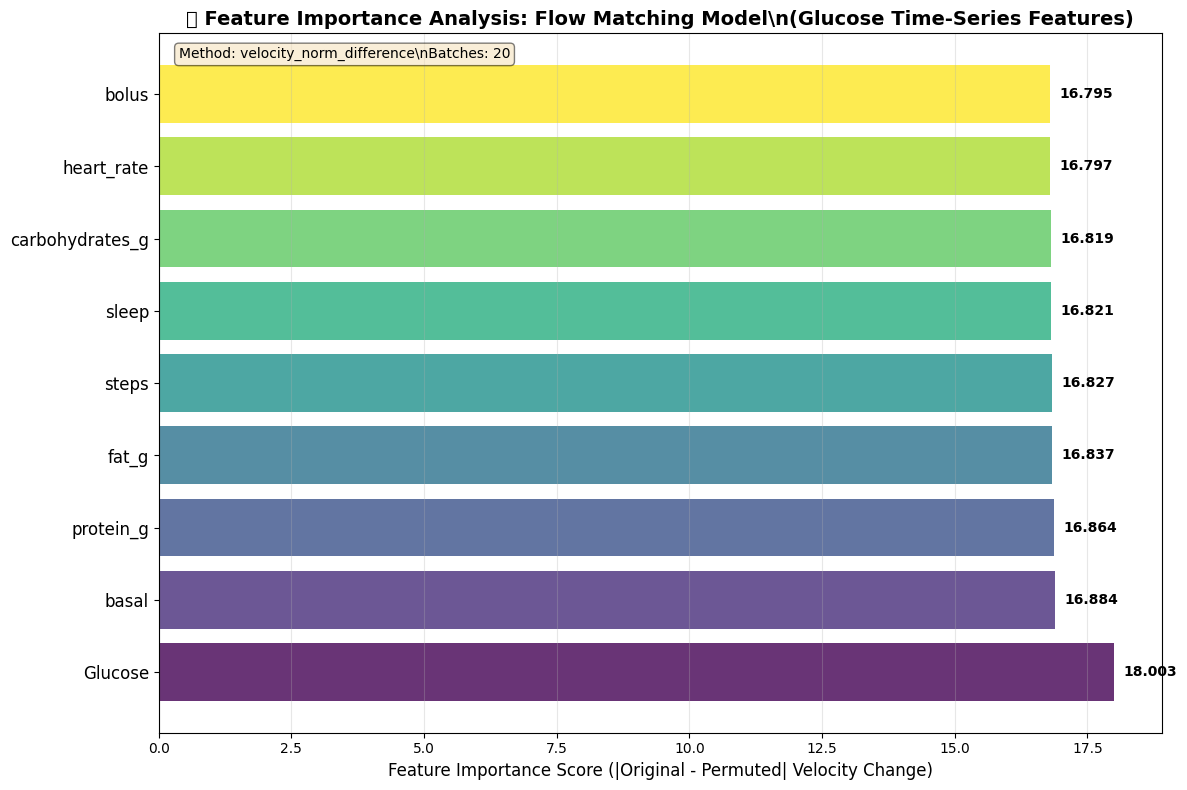

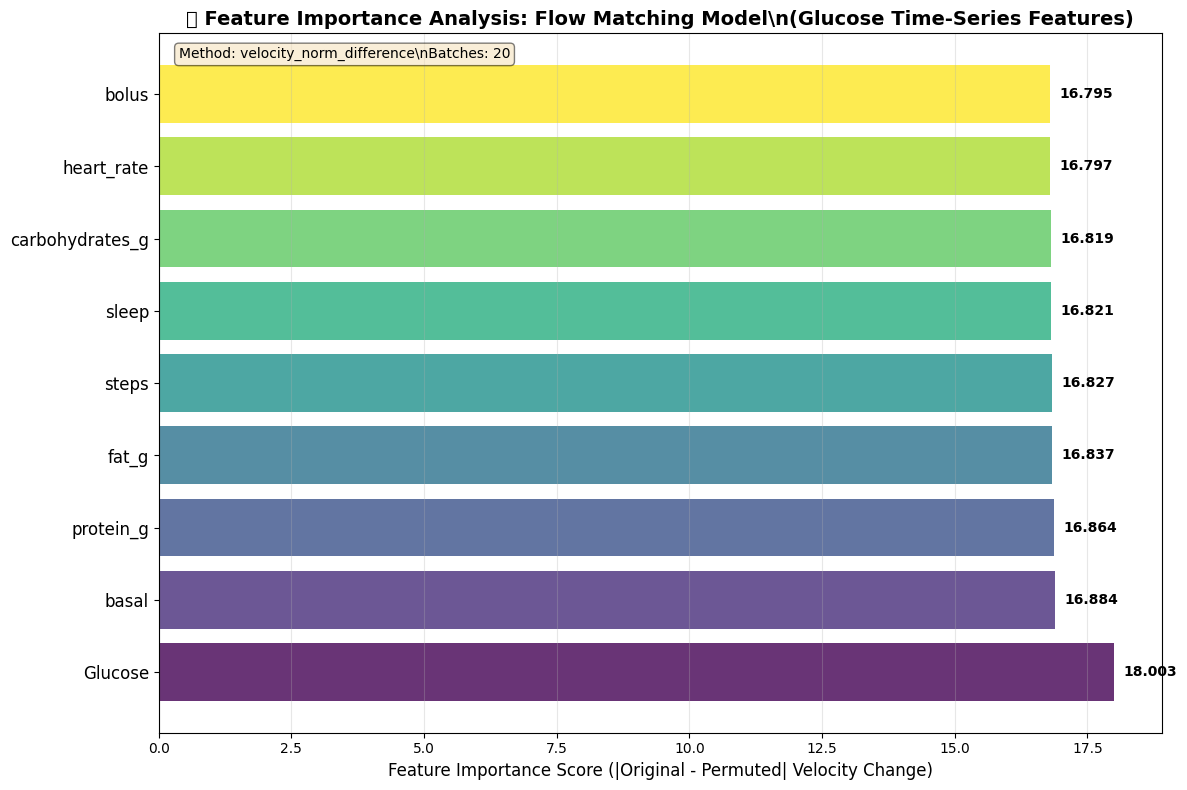

\n🎯 FEATURE IMPORTANCE RESULTS SUMMARY\n============================================================
📊 Analysis method: velocity_norm_difference
📊 Batches analyzed: 20
📊 Calculation: |original_velocity_change - permuted_velocity_change|
📊 Higher scores = more important for flow dynamics

🏆 Feature Ranking (Most to Least Important):
  🥇  1. Glucose             : 18.0034
  🥈  2. basal               : 16.8840
  🥉  3. protein_g           : 16.8636
  📍  4. fat_g               : 16.8374
  📍  5. steps               : 16.8275
  📍  6. sleep               : 16.8206
  📍  7. carbohydrates_g     : 16.8188
  📍  8. heart_rate          : 16.7973
  📍  9. bolus               : 16.7952
\n============================================================
🔍 KEY INSIGHT:
   • Most important feature: Glucose (score: 18.0034)
   • This feature has the largest impact on flow velocity dynamics
   • Permuting this feature causes the biggest changes in model behavior


In [19]:
# Visualization of results
%matplotlib inline
def plot_feature_importance(results):
    """Simple visualization of feature importance results."""
    
    if 'feature_importance' not in results or not results['feature_importance']:
        print("❌ No feature importance results to plot")
        return
    
    feature_names = list(results['feature_importance'].keys())
    importance_scores = list(results['feature_importance'].values())
    
    # Sort by importance
    sorted_indices = np.argsort(importance_scores)[::-1]
    sorted_names = [feature_names[i] for i in sorted_indices]
    sorted_scores = [importance_scores[i] for i in sorted_indices]
    
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Color palette
    colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_names)))
    
    bars = ax.barh(range(len(sorted_names)), sorted_scores, color=colors, alpha=0.8)
    ax.set_yticks(range(len(sorted_names)))
    ax.set_yticklabels(sorted_names, fontsize=12)
    ax.set_xlabel('Feature Importance Score (|Original - Permuted| Velocity Change)', fontsize=12)
    ax.set_title('🔍 Feature Importance Analysis: Flow Matching Model\\n(Glucose Time-Series Features)', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add value labels on bars
    for i, (bar, score) in enumerate(zip(bars, sorted_scores)):
        ax.text(score + max(sorted_scores)*0.01, bar.get_y() + bar.get_height()/2, 
                f'{score:.3f}', va='center', fontsize=10, fontweight='bold')
    
    # Add method info
    method = results.get('method', 'unknown')
    n_batches = results.get('n_batches', 'unknown')
    ax.text(0.02, 0.98, f'Method: {method}\\nBatches: {n_batches}', 
            transform=ax.transAxes, fontsize=10, va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed summary
    print("\\n" + "🎯 FEATURE IMPORTANCE RESULTS SUMMARY" + "\\n" + "="*60)
    print(f"📊 Analysis method: {results.get('method', 'Unknown')}")
    print(f"📊 Batches analyzed: {results.get('n_batches', 'Unknown')}")
    print(f"📊 Calculation: |original_velocity_change - permuted_velocity_change|")
    print(f"📊 Higher scores = more important for flow dynamics")
    print()
    
    print("🏆 Feature Ranking (Most to Least Important):")
    for i, (feature, score) in enumerate(zip(sorted_names, sorted_scores), 1):
        # Add emoji for top features
        emoji = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "📍"
        print(f"  {emoji} {i:2d}. {feature:20s}: {score:.4f}")
    
    print("\\n" + "="*60)
    
    # Interpretation
    if sorted_scores:
        top_feature = sorted_names[0]
        top_score = sorted_scores[0]
        print(f"🔍 KEY INSIGHT:")
        print(f"   • Most important feature: {top_feature} (score: {top_score:.4f})")
        print(f"   • This feature has the largest impact on flow velocity dynamics")
        print(f"   • Permuting this feature causes the biggest changes in model behavior")

# Create visualization
plot_feature_importance(results)


In [ ]:
# Summary

print("📋 ANALYSIS SUMMARY")
print("="*50)
print()
print("✅ Successfully implemented feature importance analysis with raw velocities!")
print() 
print("🔧 Method:")
print("   • Simple permutation within batches")
print("   • For each feature: permute values across batch samples")
print("   • Returns raw velocity values [batch, num_time_steps, velo_dim]")
print("   • Calculate: norm of [vel - vel_permu]")
print("   • Average across multiple batches")
print()
print("📊 Features analyzed:")
feature_names = ['bolus', 'basal', 'heart_rate', 'steps', 'sleep', 'fat_g', 'protein_g', 'carbohydrates_g', 'Glucose']
for i, name in enumerate(feature_names, 1):
    print(f"   {i}. {name}")
print()
print("🎯 Interpretation:")
print("   • Higher scores = more important for flow dynamics")
print("   • Scores show impact on model's temporal behavior") 
print("   • Permuting important features disrupts velocity patterns more")
print("   • Uses full velocity tensor information (not just magnitudes)")
print()
print("🚀 Key improvements:")
print("   • Returns raw velocity values across time")
print("   • Uses norm of velocity difference for importance")
print("   • Proper CUDA loading: new_batch.append([t.cuda() for t in batch[0]])")
print("   • Full tensor comparison instead of scalar magnitudes")
print()
print("="*50)
